# data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
#import s3fs
import io
import scikitplot as skplt


sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [2]:
df_combined = pd.read_csv('data/exported/df_combined.csv', index_col = 0)
df_not_combined = pd.read_csv('data/exported/df_not_combined.csv', index_col = 0)
#df_yeast_not_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_not_combined.csv']), index_col = 0)
#df_yeast_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_combined.csv']), index_col = 0)

# modelling packages

In [3]:
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [5]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_combined = df_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [6]:
seed = 7

## train test split

In [7]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [8]:
# prepare whole dataframe subsets according to train test split

df_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
df_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
df_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
df_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]

In [9]:
# function to get dataframe into x and y array with format (reads, ref_pos, features) to be able use ref_pos
# as time step in rnn

def prepare_rnn_data (df):
     
    # dummify base sequence and concatenate into temp dataframe with numeric values from source dataframe
    
    df_dum = pd.get_dummies(df[["base_1","base_2","base_3","base_4","base_5"]])
    df_dum = pd.concat([df, df_dum], axis = 1)
    df_dum = df_dum.drop(["base_1","base_2","base_3","base_4","base_5"], axis = 1)
    
    df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]
    
    # feature 3d array:
    # nested for loop over file name, ref_num and read_num to iterate over every unique possible read and concatenate
    # x and y values into a list of lists
    
    X = []
    y= []
    
    for file_name in df_dum.file_name.unique():
        msk1 = df_dum[df_dum.file_name == file_name]
        for ref_num in msk1.ref_number.unique():
            msk2 = msk1[msk1.ref_number == ref_num]
            for read_num in msk2.read_num.unique():
                msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
                X.append(df_dum_num[msk3])
                y.append(df_dum[msk3].modified_status.astype(int))
  
    #stack resulting lists into a 3d numpy array
    
    X = np.stack(X)
    y = np.stack(y)
    
    return X, y

In [10]:
# prepare each dataframe combination with function

X_3d_train, y_3d_train = prepare_rnn_data(df_train_not_combined)
X_3d_test, y_3d_test = prepare_rnn_data(df_test_not_combined)
X_3d_finaltest, y_3d_finaltest = prepare_rnn_data(df_finaltest_not_combined)
X_3d_val, y_3d_val = prepare_rnn_data(df_val_not_combined)

# rnn

In [11]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [12]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [13]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [14]:
import tensorflow.keras.backend as kb

In [15]:
class rnn_constructor():
    
    def __init__(self, model, instance_name, custom_loss_state = False):
       
        self.custom_loss_state = custom_loss_state
        self.instance_name = instance_name
        self.model = model
        self.validation_split = 0.2
        self.features = 1
        self.n_train = 1
        self.buffer_size = 1
        self.batch_size = 1
        self.steps_per_epoch = self.n_train//self.batch_size
        self.metrics = [tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy')]
        self.lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                                          0.1,
                                                                          decay_steps=self.steps_per_epoch*350,
                                                                          decay_rate=1,
                                                                          staircase=False)
        self.history = {}
        self.class_weight=None
        self.pos_weight = None
        self.loss = None
        self.classification_report = None
   
    def __custom_loss__(self, y_actual,y_pred):
        y_actual = tf.cast(y_actual, dtype="float32")
        custom_loss=tf.nn.weighted_cross_entropy_with_logits(labels=y_actual, logits=y_pred, 
                                                             pos_weight = self.pos_weight, name="loss")
        return custom_loss
    

    def __get_class_weights__(self, y):
        class_weight_list = compute_class_weight("balanced", np.unique(y), y.flatten()) 
        self.class_weight = dict(zip(np.unique(y), class_weight_list))
    
        
    def __get_callbacks__(self):
        return [
            tfdocs.modeling.EpochDots(),
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50),
                ]
    
    def __get_optimizer__(self):
        return tf.keras.optimizers.Adam(self.lr_schedule)
    
    def __model_compile__(self):
        if self.custom_loss_state:
            self.loss = self.__custom_loss__
        else:
            self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        optimizer = self.__get_optimizer__()
        self.model.compile(optimizer=optimizer,
                    loss=self.loss,
                    metrics=self.metrics,
                     )

        self.model.summary()
    
    def __model_fit__(self, X, y, batch_size = 20, epochs = 2500, class_weight = True):
        
        
        self.features = X.shape[2]
        self.n_train = len(X) * (1-self.validation_split)
        self.buffer_size = len(X)
        self.batch_size = batch_size
        self.steps_per_epoch = self.n_train//self.batch_size
        self.history[self.instance_name] = self.model.fit(
                                x=X,
                                y=y,
                                batch_size=self.batch_size,
                                steps_per_epoch = self.steps_per_epoch,
                                epochs=epochs,
                                #validation_data=(X_3d_val, y_3d_val),
                                callbacks=self.__get_callbacks__(),
                                verbose=0,
                                workers = 8,
                                class_weight = self.class_weight,
                                use_multiprocessing = True,
                                shuffle=True,
                                validation_split=self.validation_split
                                    )
    
    def compile_and_fit(self, X, y, batch_size = 20, epochs = 2500, class_weight = True):
        
        if self.custom_loss_state == True:
            self.__get_class_weights__(y)
            self.pos_weight = self.class_weight[1]
            self.class_weight = None
        if class_weight == True:
            self.__get_class_weights__(y)
        
        
        self.__model_compile__()
        self.__model_fit__( X, y, batch_size = 20, epochs = 2500)
        return self.history
    
    def plot_training(self, metric = 'loss'):
        
        plotter = tfdocs.plots.HistoryPlotter(metric = metric, smoothing_std=10)
        plotter.plot(self.history)
        
    def plot_evaluation(self, x_train, y_train):
        y_pred = self.model.predict_classes(x_train)
        skplt.metrics.plot_confusion_matrix(y_train.flatten(),y_pred.flatten(), figsize=(10,10), text_fontsize=20)
        self.classification_report = classification_report(y_train.flatten(),y_pred.flatten(), output_dict = True)
        print(classification_report(y_train.flatten(),y_pred.flatten()))
        return {self.instance_name:self.classification_report["1"]["f1-score"]}

In [16]:
histories = {}
f1_scores = {}

In [17]:
# rnn model

model_class_weight = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(196,26),return_sequences=True),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Dropout(0.5,seed = seed),
    tf.keras.layers.Dense(1)
])

In [18]:
rnn_class_weight = rnn_constructor(model_class_weight, "rnn_class_weight", custom_loss_state = False)

In [19]:
hist = rnn_class_weight.compile_and_fit(X_3d_train, y_3d_train, class_weight = True)
histories.update(hist)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 196, 32)           7552      
_________________________________________________________________
dropout (Dropout)            (None, 196, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 196, 64)           16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 64)           0         
_________________________________________________________________
dense (Dense)                (None, 196, 1)            65        
Total params: 24,257
Trainable params: 24,257
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch: 0, binary_crossentropy:0.2559,  loss:2.2437,  val_binary_cro

In [197]:
rnn_class_weight.class_weight

{0: 0.5166959578207382, 1: 15.473684210526315}

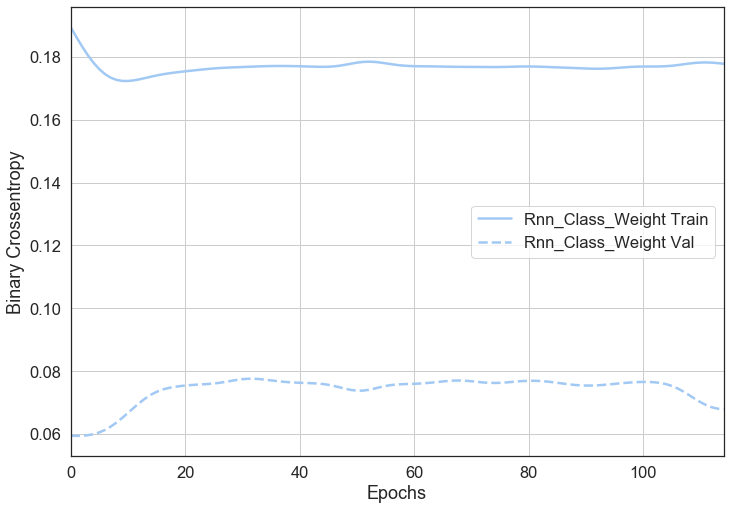

In [198]:
rnn_class_weight.plot_training(metric = "binary_crossentropy")

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     43470
           1       0.00      0.00      0.00      1610

    accuracy                           0.96     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.96      0.94     45080



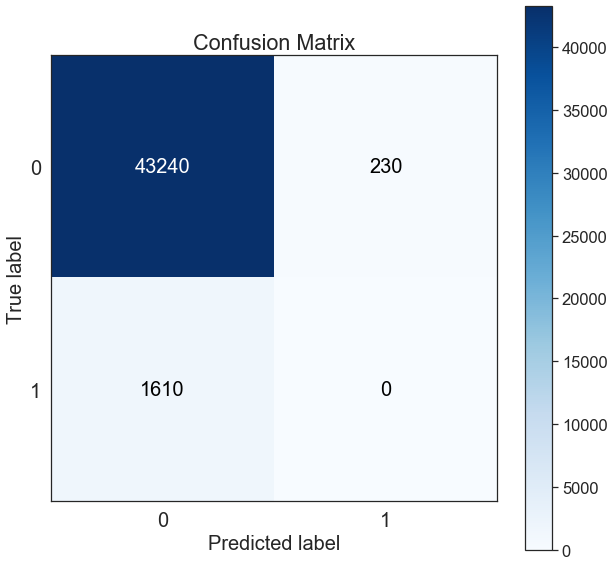

In [199]:
f1 = rnn_class_weight.plot_evaluation(X_3d_test, y_3d_test)
f1_scores.update(f1)